In [9]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config IPCompleter.greedy = True

#Formato sin notación científica
pd.options.display.float_format = '{:15.2f}'.format 

#Automcompletar rápido
%config IPCompleter.greedy=True

#Desactivar la notación científica
pd.options.display.float_format = '{:.2f}'.format

#Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

#Mostrar el máximo de filas posibles de una tabla
pd.set_option('display.max_rows', 100) #Número de filas que deben verse. None = Máx

#Mostrar el máximo de columnas posibles de una tabla
pd.set_option('display.max_columns', None) #Número de columnas que deben verse. None = Máx

#Mostrar mas caracteres de las columnas. Se usa cuando se corta el texto
pd.set_option('display.max_colwidth', None) #Número de caractres que deben verse. None = Máx

# Dataset de viviendas en Madrid (Idealista 2018)

## Introducción

Este dataset recoge información detallada y georreferenciada sobre anuncios inmobiliarios en Madrid en 2018, extraída de Idealista y publicada originalmente por Antonio Páez. Incluye más de **180.000 viviendas** (Madrid, Barcelona y Valencia, aunque aquí nos centramos en Madrid), con datos de precios, características del inmueble y variables espaciales relevantes para estudios urbanos y análisis del mercado inmobiliario.

El dataset original se distribuye como un objeto `sf` en R (`idealista18`). En esta versión se ha convertido a **CSV**, manteniendo prácticamente todas las variables originales. La única pérdida relevante es la columna geométrica de tipo punto, aunque se conservan la **latitud, longitud y múltiples medidas de distancia**, por lo que el valor analítico se mantiene intacto.

Los datos han sido anonimizados y son especialmente útiles para:

- Modelos de precios hedónicos  
- Análisis espacial y urbano  
- Estudios de accesibilidad y localización  
- Ciencia de datos aplicada al real estate  

Créditos completos a Antonio Páez y colaboradores. Cualquier error aquí es humano; la metodología original es sólida.

---

## Descripción de las columnas

### Identificación y tiempo
- **ASSETID**: Identificador único de cada vivienda.
- **PERIOD**: Periodo temporal del anuncio en formato `YYYYMM`.

### Precio y superficie
- **PRICE**: Precio total del inmueble (€).
- **UNITPRICE**: Precio por metro cuadrado (€ / m²).
- **CONSTRUCTEDAREA**: Superficie construida en metros cuadrados.

### Distribución
- **ROOMNUMBER**: Número total de habitaciones.
- **BATHNUMBER**: Número de baños.

### Características del inmueble (binarias: 1 = sí, 0 = no)
- **HASTERRACE**: Tiene terraza.
- **HASLIFT**: Tiene ascensor.
- **HASAIRCONDITIONING**: Tiene aire acondicionado.
- **HASPARKINGSPACE**: Incluye plaza de parking.
- **ISPARKINGSPACEINCLUDEDINPRICE**: El parking está incluido en el precio.
- **HASNORTHORIENTATION**: Orientación norte.
- **HASSOUTHORIENTATION**: Orientación sur.
- **HASEASTORIENTATION**: Orientación este.
- **HASWESTORIENTATION**: Orientación oeste.
- **HASBOXROOM**: Tiene trastero.
- **HASWARDROBE**: Tiene armarios empotrados.
- **HASSWIMMINGPOOL**: Tiene piscina.
- **HASDOORMAN**: Tiene portero o conserje.
- **HASGARDEN**: Tiene jardín.
- **ISDUPLEX**: Es un dúplex.
- **ISSTUDIO**: Es un estudio.
- **ISINTOPFLOOR**: Está en la última planta.

### Parking
- **PARKINGSPACEPRICE**: Precio de la plaza de parking. En este dataset parece un valor fijo o marcador; conviene tratarlo con cautela.

### Año y planta
- **CONSTRUCTIONYEAR**: Año de construcción (puede contener NA).
- **FLOORCLEAN**: Planta del inmueble.
- **FLATLOCATIONID**: Código interno de localización del piso (requiere documentación adicional).

### Información catastral
- **CADCONSTRUCTIONYEAR**: Año de construcción según catastro.
- **CADMAXBUILDINGFLOOR**: Número máximo de plantas del edificio.
- **CADDWELLINGCOUNT**: Número de viviendas en el edificio.
- **CADASTRALQUALITYID**: Clasificación de calidad catastral del inmueble.

### Tipo de vivienda
- **BUILTTYPEID_1**: Obra nueva.
- **BUILTTYPEID_2**: Segunda mano para reformar.
- **BUILTTYPEID_3**: Segunda mano en buen estado.

### Variables espaciales
- **DISTANCE_TO_CITY_CENTER**: Distancia al centro de la ciudad (km).
- **DISTANCE_TO_METRO**: Distancia a la estación de metro más cercana (km).
- **DISTANCE_TO_MAIN_AVENUE**: Distancia al Paseo de la Castellana (km).

### Geolocalización
- **LONGITUDE**: Longitud geográfica.
- **LATITUDE**: Latitud geográfica.

### Otros
- **AMENITYID**: Código de amenities asociados al inmueble. El significado exacto no está documentado públicamente, por lo que se recomienda tratarlo como variable categórica opaca.


In [2]:
df = pd.read_csv('../Practicas/Madrid_Sale.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94815 entries, 0 to 94814
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ASSETID                        94815 non-null  object 
 1   PERIOD                         94815 non-null  int64  
 2   PRICE                          94815 non-null  float64
 3   UNITPRICE                      94815 non-null  float64
 4   CONSTRUCTEDAREA                94815 non-null  int64  
 5   ROOMNUMBER                     94815 non-null  int64  
 6   BATHNUMBER                     94815 non-null  int64  
 7   HASTERRACE                     94815 non-null  int64  
 8   HASLIFT                        94815 non-null  int64  
 9   HASAIRCONDITIONING             94815 non-null  int64  
 10  AMENITYID                      94815 non-null  int64  
 11  HASPARKINGSPACE                94815 non-null  int64  
 12  ISPARKINGSPACEINCLUDEDINPRICE  94815 non-null 

In [4]:
df.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,ISPARKINGSPACEINCLUDEDINPRICE,PARKINGSPACEPRICE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,CONSTRUCTIONYEAR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_CASTELLANA,LONGITUDE,LATITUDE
0,A15019136831406238029,201803,126000.00,2680.85,47,1,1,0,1,1,3,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,2005.00,1.00,1.00,2005,7,319,3.00,0,1,0,8.06,0.87,6.87,-3.77,40.36
1,A6677225905472065344,201803,235000.00,4351.85,54,1,1,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,1.00,2.00,1900,5,11,3.00,0,0,1,0.88,0.12,1.54,-3.71,40.42
2,A13341979748618524775,201803,373000.00,4973.33,75,2,1,0,0,1,3,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,NaN,3.00,1.00,1915,6,26,3.00,0,0,1,0.91,0.14,1.61,-3.71,40.42
3,A4775182175615276542,201803,284000.00,5916.67,48,1,1,0,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,1.00,2.00,1947,9,15,5.00,0,0,1,0.85,0.14,1.52,-3.71,40.42
4,A2492087730711701973,201803,228000.00,4560.00,50,0,1,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1930.00,0.00,1.00,1930,5,19,7.00,0,0,1,1.25,0.34,1.79,-3.71,40.41


In [5]:
df.shape

(94815, 41)

In [6]:
df = df.set_index('ASSETID')
df.head()

,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,ISPARKINGSPACEINCLUDEDINPRICE,PARKINGSPACEPRICE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,CONSTRUCTIONYEAR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_CASTELLANA,LONGITUDE,LATITUDE
ASSETID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A15019136831406238029,201803,126000.00,2680.85,47,1,1,0,1,1,3,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,2005.00,1.00,1.00,2005,7,319,3.00,0,1,0,8.06,0.87,6.87,-3.77,40.36
A6677225905472065344,201803,235000.00,4351.85,54,1,1,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,1.00,2.00,1900,5,11,3.00,0,0,1,0.88,0.12,1.54,-3.71,40.42
A13341979748618524775,201803,373000.00,4973.33,75,2,1,0,0,1,3,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,NaN,3.00,1.00,1915,6,26,3.00,0,0,1,0.91,0.14,1.61,-3.71,40.42
A4775182175615276542,201803,284000.00,5916.67,48,1,1,0,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,1.00,2.00,1947,9,15,5.00,0,0,1,0.85,0.14,1.52,-3.71,40.42
A2492087730711701973,201803,228000.00,4560.00,50,0,1,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1930.00,0.00,1.00,1930,5,19,7.00,0,0,1,1.25,0.34,1.79,-3.71,40.41


In [8]:
df_pearson = df.select_dtypes(include=['number', 'bool']).corr(method = 'pearson')
df_pearson

,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,ISPARKINGSPACEINCLUDEDINPRICE,PARKINGSPACEPRICE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,CONSTRUCTIONYEAR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_CASTELLANA,LONGITUDE,LATITUDE
PERIOD,1.00,0.01,0.06,-0.02,-0.02,-0.01,0.00,0.02,0.03,0.01,-0.01,-0.01,0.01,0.01,0.02,0.02,0.03,-0.01,0.00,-0.00,0.00,0.01,-0.00,0.01,0.01,0.00,-0.00,0.01,-0.01,0.01,-0.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,-0.01,0.00,0.02
PRICE,0.01,1.00,0.59,0.86,0.46,0.72,0.06,0.32,0.14,-0.01,0.22,0.22,0.05,0.05,0.08,0.05,0.10,0.22,0.14,0.10,0.35,0.07,0.06,-0.07,0.03,-0.06,0.18,-0.11,-0.07,0.17,-0.00,-0.46,0.01,0.06,-0.06,-0.20,-0.01,-0.25,-0.04,0.25
UNITPRICE,0.06,0.59,1.00,0.22,-0.05,0.28,-0.13,0.34,0.19,0.01,0.07,0.07,0.06,0.03,0.05,0.04,0.07,0.05,0.17,0.05,0.28,-0.02,0.01,0.08,0.03,-0.14,0.14,0.19,-0.25,0.15,0.01,-0.50,-0.00,-0.04,0.04,-0.42,-0.06,-0.43,-0.07,0.35
CONSTRUCTEDAREA,-0.02,0.86,0.22,1.00,0.64,0.78,0.17,0.29,0.10,-0.01,0.29,0.29,0.05,0.05,0.09,0.06,0.10,0.29,0.14,0.16,0.32,0.15,0.09,-0.12,0.03,0.01,0.17,-0.22,0.05,0.17,0.04,-0.37,0.03,0.09,-0.10,-0.04,0.03,-0.10,-0.01,0.18
ROOMNUMBER,-0.02,0.46,-0.05,0.64,1.00,0.59,0.20,0.15,-0.03,-0.01,0.15,0.15,0.02,0.04,0.05,0.05,0.07,0.16,0.05,0.04,0.18,0.08,0.00,-0.35,-0.01,-0.02,0.16,-0.23,0.03,0.14,0.02,-0.13,-0.01,0.18,-0.16,0.05,0.02,0.01,-0.00,0.05
BATHNUMBER,-0.01,0.72,0.28,0.78,0.59,1.00,0.13,0.32,0.15,-0.01,0.33,0.33,0.05,0.05,0.08,0.06,0.08,0.30,0.19,0.23,0.32,0.21,0.11,-0.10,0.01,0.04,0.15,-0.17,0.09,0.19,0.10,-0.38,0.08,0.01,-0.04,-0.01,0.05,-0.07,0.02,0.19
HASTERRACE,0.00,0.06,-0.13,0.17,0.20,0.13,1.00,0.07,0.06,0.02,0.13,0.13,0.01,0.06,0.08,0.07,0.06,0.12,0.13,0.09,0.08,0.14,0.05,-0.07,0.09,0.12,0.18,-0.19,0.19,0.06,0.03,0.03,0.06,0.04,-0.06,0.18,0.05,0.13,0.03,-0.00
HASLIFT,0.02,0.32,0.34,0.29,0.15,0.32,0.07,1.00,0.16,0.01,0.29,0.29,0.05,0.05,0.06,0.06,0.07,0.24,0.26,0.26,0.35,0.24,0.02,-0.02,-0.00,0.14,0.24,-0.05,0.20,0.37,0.25,-0.37,0.12,-0.02,-0.03,0.01,0.02,-0.06,0.07,0.20
HASAIRCONDITIONING,0.03,0.14,0.19,0.10,-0.03,0.15,0.06,0.16,1.00,-0.00,0.17,0.17,0.04,0.06,0.11,0.10,0.09,0.14,0.35,0.14,0.17,0.15,0.07,0.02,0.06,0.08,0.11,-0.06,0.10,0.05,0.10,-0.14,-0.14,-0.23,0.28,0.01,0.02,-0.02,0.03,0.07
AMENITYID,0.01,-0.01,0.01,-0.01,-0.01,-0.01,0.02,0.01,-0.00,1.00,-0.01,-0.01,0.02,-0.00,0.02,0.02,-0.00,-0.01,0.02,-0.00,0.03,0.01,0.01,0.01,0.01,-0.02,0.00,0.00,-0.02,0.00,-0.01,0.00,0.04,-0.01,-0.01,-0.02,-0.01,-0.02,-0.01,0.01


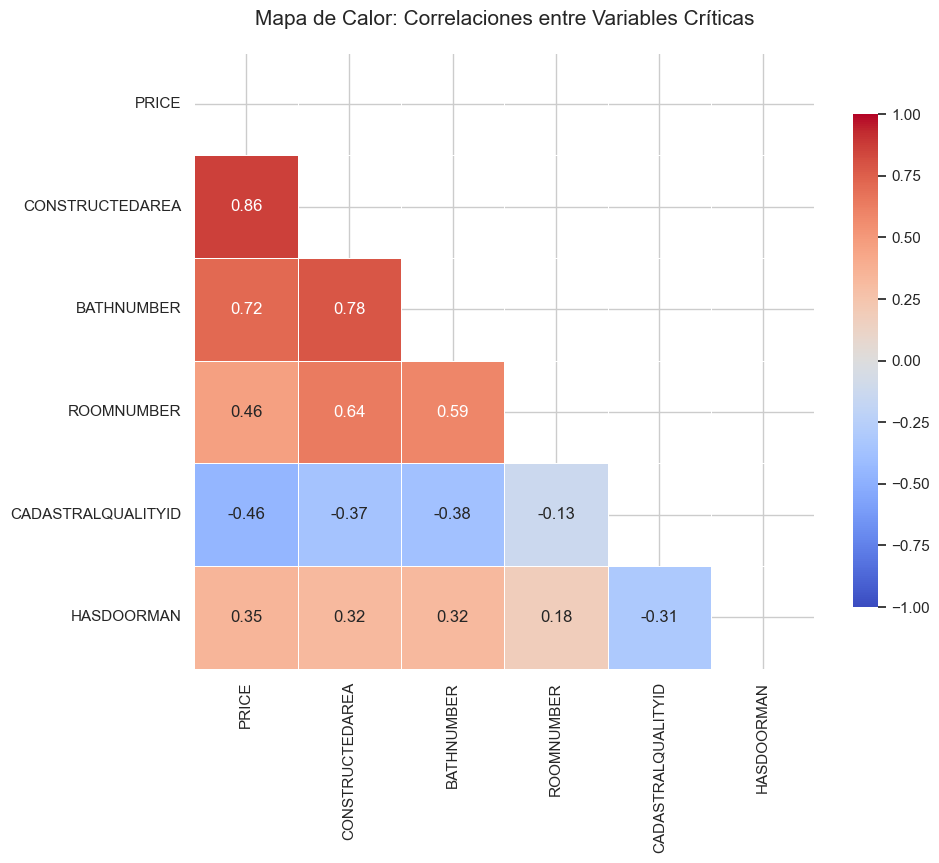

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Usamos la misma lista de variables clave
variables_clave = [
    'PRICE', 
    'CONSTRUCTEDAREA', 
    'BATHNUMBER', 
    'ROOMNUMBER', 
    'CADASTRALQUALITYID',
    'HASDOORMAN'
]

# 2. Calculamos la matriz de correlación solo para esas variables
corr_subset = df[variables_clave].corr()

# 3. Configuramos el gráfico
plt.figure(figsize=(10, 8))

# Creamos una máscara para tapar la mitad superior (opcional, pero queda más limpio)
mask = np.triu(np.ones_like(corr_subset, dtype=bool))

# 4. Dibujamos el heatmap
sns.heatmap(
    corr_subset, 
    mask=mask,
    annot=True,           # Muestra los números dentro de los cuadros
    fmt=".2f",            # Dos decimales
    cmap='coolwarm',      # Azul (negativo) a Rojo (positivo)
    vmin=-1, vmax=1,      # Escala fija de la correlación de Pearson
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Mapa de Calor: Correlaciones entre Variables Críticas', fontsize=15, pad=20)
plt.show()

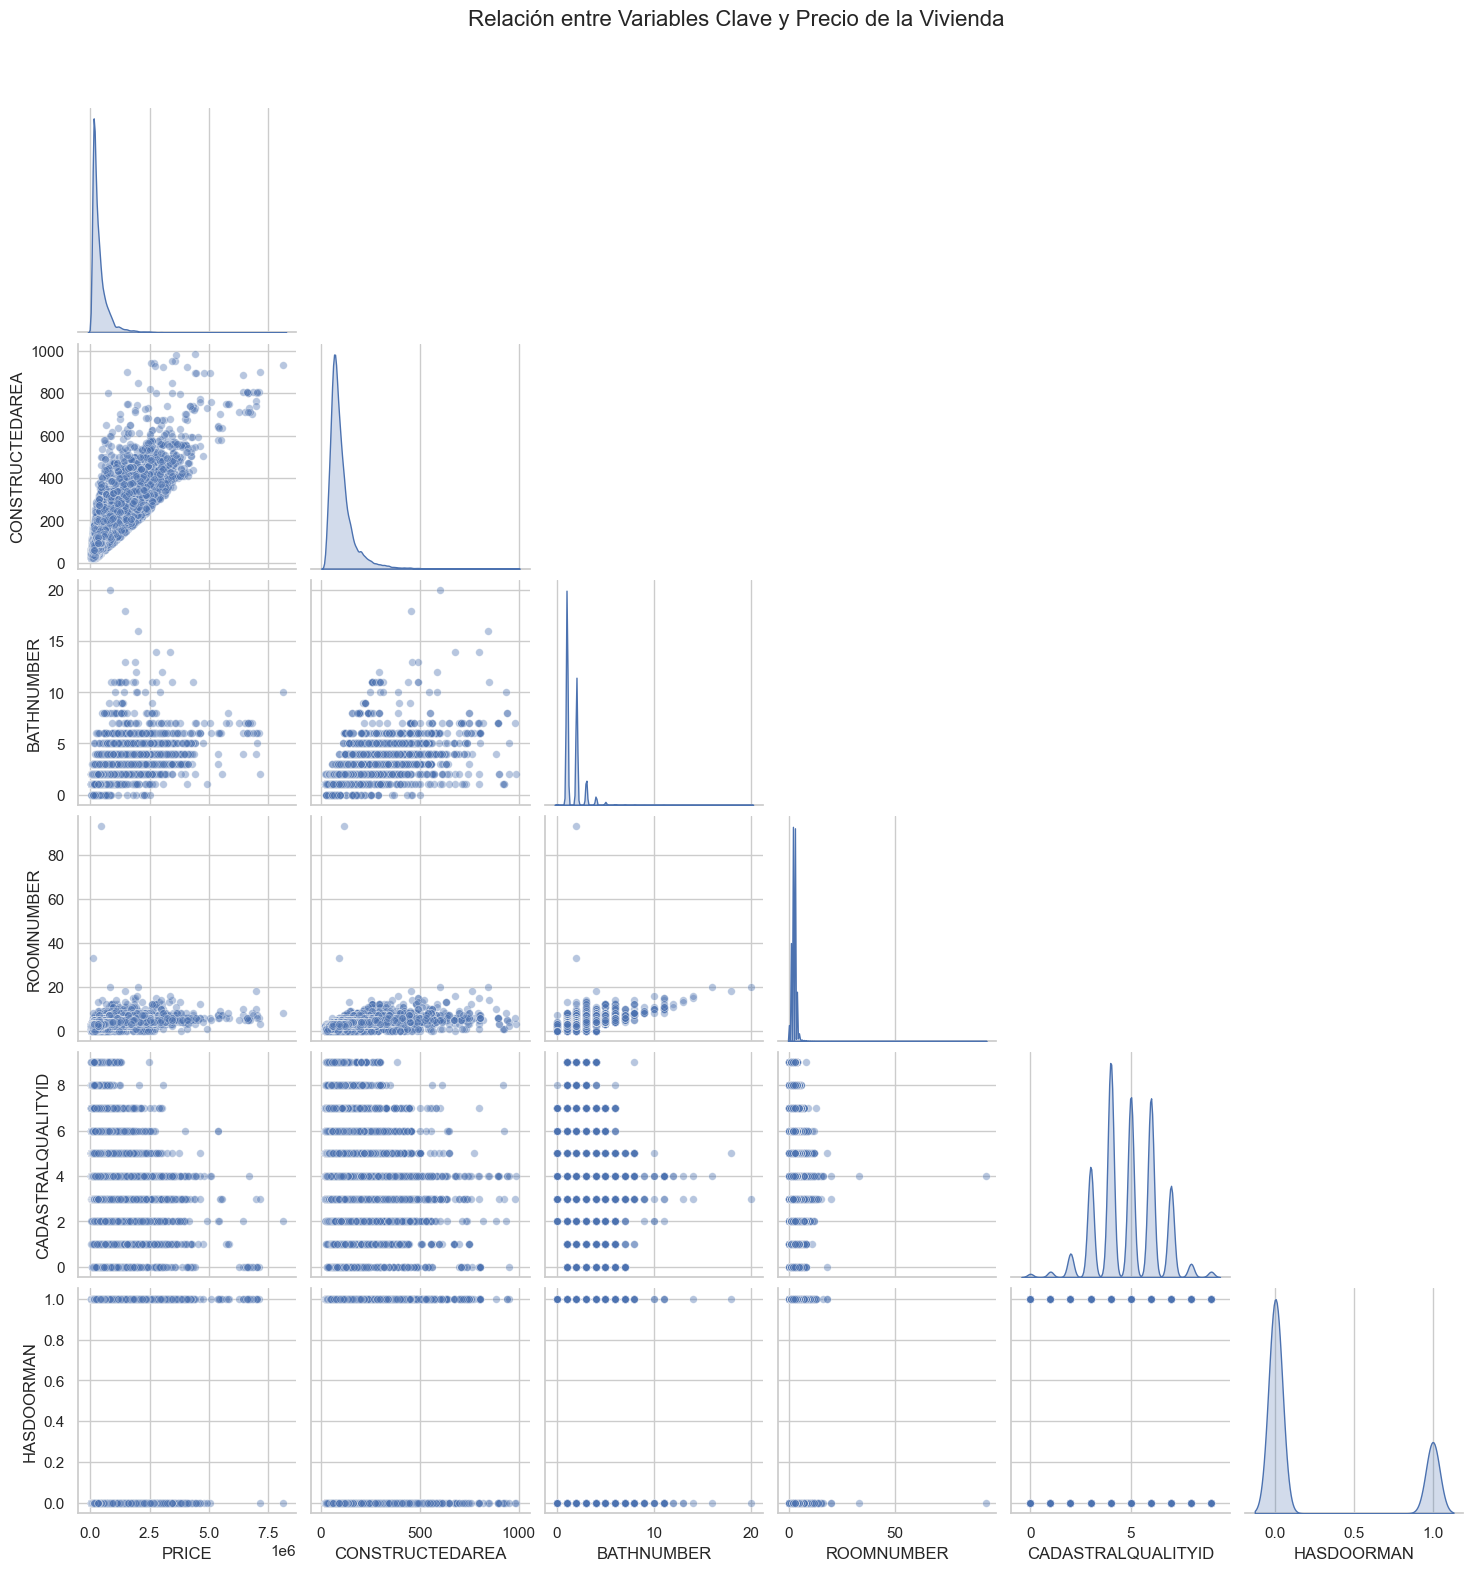

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definimos la lista de variables basada en el análisis de correlación
variables_clave = [
    'PRICE', 
    'CONSTRUCTEDAREA', 
    'BATHNUMBER', 
    'ROOMNUMBER', 
    'CADASTRALQUALITYID',
    'HASDOORMAN'
]

# 2. Creamos un sub-dataframe solo con esas columnas y eliminamos nulos para el gráfico
df_grafico = df[variables_clave].dropna()

# 3. Configuramos el estilo visual
sns.set_theme(style="whitegrid")

# 4. Creamos el pairplot
# height=2.5 controla el tamaño de cada subgráfico
# corner=True evita mostrar la mitad superior duplicada
# plot_kws ayuda a que los puntos no se amontonen (transparencia y tamaño)
g = sns.pairplot(
    df_grafico, 
    kind='scatter', 
    diag_kind='kde', 
    corner=True,
    plot_kws={'alpha': 0.4, 's': 30, 'edgecolor': 'w'},
    diag_kws={'fill': True}
)

# 5. Añadimos un título general
g.fig.suptitle('Relación entre Variables Clave y Precio de la Vivienda', fontsize=16, y=1.05)

plt.show()

PRICE - CONSTRUCTEDAREA



Relación Lineal: Relación lineal positiva monotónica

El precio es predecible para casas pequeñas pero se observa dispersión del precio cuando los inmuebles son mayores (ubicación, acabados, etc.).  



BATHNUMBER y ROOMNUMBER



Como no puedes tener 2.5 baños, los puntos se alinean en niveles (1, 2, 3...). También lo vemos en la distribución 



CADASTRALQUALITYID (Calidad Catastral)



Distribución mayormente normal con picos similares por el tipo de dato no decimal que pueden contener



La mayoría de tus viviendas se agrupan en categorías de calidad 4, 5 y 6



HASDOORMAN



La distribución y el grafico scatter nos indican que es una variable binaria



Conclusion: Probablemente quitaria los outliers de las mansiones de 15 baños o 25 habitaciones porque no nos aportan datos 


In [ ]:
# Análisis de todas las variables numéricas NO BINARIAS del df. 
#   - Excluye las variables binarias por defecto para que no generen ruido
#   - variables_excluidas = []. Permite excluir varibles específicas manualmente
#   - Permite definir el número de desviaciones típicas para considera outliers en el parámetro "std_threshold=4"
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy, trim_mean, jarque_bera

def analisis_estadistico_completo(df, variables_excluidas=None, std_threshold=4):
    if variables_excluidas is None:
        variables_excluidas = []

    resultados = {}

    for col in df.select_dtypes(include=["int64", "float64"]).columns:

        # excluir explícitas
        if col in variables_excluidas:
            continue

        s = df[col].dropna()

        # excluir binarias puras 0/1
        valores_unicos = set(s.unique())
        if valores_unicos.issubset({0, 1}) and len(valores_unicos) <= 2:
            continue

        n = s.count()
        if n == 0:
            continue

        # Cálculos base
        mean = s.mean()
        std = s.std()
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        median = s.median()
        mad = np.median(np.abs(s - median))
        
        # Nombre dinámico para la columna de atípicos por STD
        col_name_std = f"outliers_std{std_threshold}"

        resultados[col] = {
            # tamaño y calidad
            "count": n,
            "missing": df[col].isna().sum(),
            "pct_missing": df[col].isna().mean(),
            "n_unique": s.nunique(),
            "pct_zeros": (s == 0).mean(),

            # tendencia central
            "mean": mean,
            "median": median,
            "mode": s.mode().iloc[0] if not s.mode().empty else np.nan,
            "trimmed_mean_10pct": trim_mean(s, 0.1),

            # dispersión
            "std": std,
            "var": s.var(),
            "cv": std / mean if mean != 0 else np.nan,
            "mad": mad,
            "robust_std": 1.4826 * mad,

            # extremos
            "min": s.min(),
            "max": s.max(),
            "range": s.max() - s.min(),
            "max_median_ratio": s.max() / median if median != 0 else np.nan,

            # cuantiles
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
            "p1": s.quantile(0.01),
            "p5": s.quantile(0.05),
            "p95": s.quantile(0.95),
            "p99": s.quantile(0.99),
            "p90_p10_range": s.quantile(0.90) - s.quantile(0.10),

            # forma
            "skewness": skew(s),
            "kurtosis": kurtosis(s),
            "iqr_asymmetry": (q3 - median) / (median - q1) if (median - q1) != 0 else np.nan,

            # outliers clásicos
            "outliers_low": (s < q1 - 1.5 * iqr).sum(),
            "outliers_high": (s > q3 + 1.5 * iqr).sum(),
            "outliers_total": ((s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)).sum(),
            "outliers_hampel": (np.abs(s - median) > 3 * mad).sum() if mad != 0 else 0,
            
            # --- NUEVA COLUMNA DINÁMICA ---
            col_name_std: ((s < mean - std_threshold * std) | (s > mean + std_threshold * std)).sum(),

            # información
            "entropy": entropy(s.value_counts(normalize=True)),

            # normalidad
            "jarque_bera_stat": jarque_bera(s)[0],
            "jarque_bera_pvalue": jarque_bera(s)[1],

            # impacto de outliers
            "outlier_impact_mean": (
                (mean - trim_mean(s, 0.1)) / mean
                if mean != 0 else np.nan
            )
        }

    return pd.DataFrame(resultados).T

estadisticos_no_binarias = analisis_estadistico_completo(df)
estadisticos_no_binarias

,count,missing,pct_missing,n_unique,pct_zeros,mean,median,mode,trimmed_mean_10pct,std,var,cv,mad,robust_std,min,max,range,max_median_ratio,q1,q3,iqr,p1,p5,p95,p99,p90_p10_range,skewness,kurtosis,iqr_asymmetry,outliers_low,outliers_high,outliers_total,outliers_hampel,outliers_std4,entropy,jarque_bera_stat,jarque_bera_pvalue,outlier_impact_mean
PERIOD,94815.00,0.00,0.00,4.00,0.00,201808.61,201809.00,201812.00,201808.89,3.68,13.58,0.00,3.00,4.45,201803.00,201812.00,9.00,1.00,201806.00,201812.00,6.00,201803.00,201803.00,201812.00,201812.00,9.00,-0.50,-1.39,1.00,0.00,0.00,0.00,0.00,0.00,1.26,11593.79,0.00,-0.00
PRICE,94815.00,0.00,0.00,2761.00,0.00,396110.11,262000.00,137000.00,313998.08,417074.41,173951061493.67,1.05,124000.00,183842.40,21000.00,8133000.00,8112000.00,31.04,160000.00,467000.00,307000.00,71000.00,97000.00,1135000.00,2207000.00,681000.00,4.04,28.98,2.01,0.00,6782.00,6782.00,14901.00,1112.00,6.73,3575315.53,0.00,0.21
UNITPRICE,94815.00,0.00,0.00,31151.00,0.00,3661.05,3480.00,2000.00,3520.38,1700.50,2891698.20,0.46,1250.16,1853.49,805.31,9997.56,9192.25,2.87,2240.00,4744.62,2504.62,1088.89,1426.67,6771.43,8584.21,4260.26,0.72,0.23,1.02,0.00,1032.00,1032.00,3238.00,0.00,9.66,8445.76,0.00,0.04
CONSTRUCTEDAREA,94815.00,0.00,0.00,558.00,0.00,101.40,83.00,60.00,89.89,67.08,4499.49,0.66,25.00,37.06,21.00,985.00,964.00,11.87,62.00,117.00,55.00,30.00,40.00,225.00,367.00,124.00,3.18,17.63,1.62,0.00,6957.00,6957.00,11621.00,942.00,5.02,1387982.70,0.00,0.11
ROOMNUMBER,94815.00,0.00,0.00,21.00,0.03,2.58,3.00,3.00,2.54,1.24,1.55,0.48,1.00,1.48,0.00,93.00,93.00,31.00,2.00,3.00,1.00,0.00,1.00,4.00,6.00,3.00,4.97,301.55,0.00,2745.00,4675.00,7420.00,536.00,257.00,1.56,359635524.37,0.00,0.02
BATHNUMBER,94815.00,0.00,0.00,18.00,0.00,1.59,1.00,1.00,1.42,0.84,0.71,0.53,0.00,0.00,0.00,20.00,20.00,20.00,1.00,2.00,1.00,1.00,1.00,3.00,5.00,2.00,2.43,14.88,NaN,0.00,3118.00,3118.00,0.00,986.00,1.02,968408.34,0.00,0.10
AMENITYID,94815.00,0.00,0.00,3.00,0.00,2.92,3.00,3.00,3.00,0.31,0.10,0.11,0.00,0.00,1.00,3.00,2.00,1.00,3.00,3.00,0.00,1.00,2.00,3.00,3.00,0.00,-4.40,19.97,NaN,6016.00,0.00,6016.00,0.00,1317.00,0.27,1880839.29,0.00,-0.03
PARKINGSPACEPRICE,94815.00,0.00,0.00,146.00,0.00,719.87,1.00,1.00,1.00,7513.88,56458337.89,10.44,0.00,0.00,1.00,925001.00,925000.00,925001.00,1.00,1.00,0.00,1.00,1.00,1.00,29987.00,0.00,52.13,5060.00,NaN,0.00,2191.00,2191.00,0.00,736.00,0.19,101192971964.35,0.00,1.00
CONSTRUCTIONYEAR,38942.00,55873.00,0.59,191.00,0.00,1964.69,1968.00,1960.00,1968.59,55.89,3123.80,0.03,16.00,23.72,1.00,2291.00,2290.00,1.16,1955.00,1987.00,32.00,1880.00,1900.00,2008.00,2018.00,85.00,-22.49,736.89,1.46,2709.00,1.00,2710.00,4182.00,41.00,4.31,884357052.70,0.00,-0.00
FLOORCLEAN,90969.00,3846.00,0.04,13.00,0.11,2.75,2.00,1.00,2.49,2.26,5.10,0.82,1.00,1.48,-1.00,11.00,12.00,5.50,1.00,4.00,3.00,-1.00,0.00,7.00,11.00,6.00,1.16,1.60,2.00,0.00,2315.00,2315.00,9990.00,0.00,2.10,30024.30,0.00,0.09


In [ ]:
# Análisis de todas las variables numéricas BINARIAS del df. 
#   - variables_excluidas = []. Permite excluir varibles específicas manualmente
import pandas as pd
import numpy as np
from scipy.stats import entropy

def analisis_binarias(df, variables_excluidas=None, rare_threshold=0.05):
    """
    Detecta y analiza variables binarias en un DataFrame de forma independiente.
    Identifica variables con 2 valores únicos (numéricas, booleanas o strings).
    """
    if variables_excluidas is None:
        variables_excluidas = []

    resultados = {}

    for col in df.columns:
        # 1. Exclusión explícita
        if col in variables_excluidas:
            continue

        s = df[col].dropna()
        n = s.count()
        
        if n == 0:
            continue

        # 2. Detección de binarias
        # Filtro: debe tener 1 o 2 valores únicos (si tiene 1 puede ser una constante binaria)
        valores_unicos = s.unique()
        if len(valores_unicos) > 2 or len(valores_unicos) == 0:
            continue
            
        # 3. Cálculo de proporciones
        # Si la variable es numérica 0/1, p1 es la media. 
        # Si es categórica, tomamos el primer valor como referencia.
        v1 = valores_unicos[0]
        p1 = (s == v1).mean()
        p0 = 1 - p1

        resultados[col] = {
            # Tamaño y calidad
            "count": n,
            "missing": df[col].isna().sum(),
            "pct_missing": df[col].isna().mean(),
            "n_unique": len(valores_unicos),
            "val_ref": v1, # Guardamos qué valor representa el pct_ref

            # Proporciones
            "pct_ref": p1,
            "pct_others": p0,
            "imbalance": abs(p1 - p0),

            # Dispersión (Bernoulli variance)
            "variance": p1 * p0,

            # Información
            "entropy": entropy([p0, p1]) if p0 > 0 and p1 > 0 else 0,

            # Diagnóstico
            "is_constant": len(valores_unicos) == 1,
            "is_rare_event": p1 < rare_threshold or p1 > (1 - rare_threshold)
        }

    return pd.DataFrame(resultados).T

estadisticos_binarias = analisis_binarias(df)
estadisticos_binarias

,count,missing,pct_missing,n_unique,val_ref,pct_ref,pct_others,imbalance,variance,entropy,is_constant,is_rare_event
HASTERRACE,94815,0,0.00,2,0,0.64,0.36,0.29,0.23,0.65,False,False
HASLIFT,94815,0,0.00,2,1,0.70,0.30,0.39,0.21,0.61,False,False
HASAIRCONDITIONING,94815,0,0.00,2,1,0.45,0.55,0.10,0.25,0.69,False,False
HASPARKINGSPACE,94815,0,0.00,2,0,0.77,0.23,0.55,0.17,0.53,False,False
ISPARKINGSPACEINCLUDEDINPRICE,94815,0,0.00,2,0,0.77,0.23,0.55,0.17,0.53,False,False
HASNORTHORIENTATION,94815,0,0.00,2,0,0.89,0.11,0.78,0.10,0.34,False,False
HASSOUTHORIENTATION,94815,0,0.00,2,0,0.76,0.24,0.53,0.18,0.55,False,False
HASEASTORIENTATION,94815,0,0.00,2,0,0.80,0.20,0.59,0.16,0.50,False,False
HASWESTORIENTATION,94815,0,0.00,2,0,0.85,0.15,0.70,0.13,0.42,False,False
HASBOXROOM,94815,0,0.00,2,1,0.26,0.74,0.48,0.19,0.57,False,False
